In [1]:
import scipy.io
import collections
import numpy as np
from theano import config
from sklearn import preprocessing

# mat = scipy.io.loadmat('data/mackeyglass.mat')
# x = np.array(preprocessing.MinMaxScaler(feature_range=(0.1, 0.9)).fit_transform(mat['X']), config.floatX)

def mackey_glass(sample_len=1000, tau=17, seed=None, n_samples = 1):
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - sample_len: length of the time-series in timesteps. Default is 1000.
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild 
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
        - n_samples : number of samples to generate
    '''
    delta_t = 10
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples

x = mackey_glass(sample_len=2500)
x = np.squeeze(x)[:,np.newaxis]
x = np.array(preprocessing.MinMaxScaler(feature_range=(0.1, 0.9)).fit_transform(x), config.floatX)


N = len(x)
s_noise = 0.5
nu = np.random.randn(N,) * s_noise

n = 0
m = n + (N // 2)
w = 1
y_train = x[n+w:m+w]
X_train = x[n:m]

n = m + 1
m = N - w - 1
y_test = x[n+w:m+w]
X_test = x[n:m]

Couldn't import dot_parser, loading of dot files will not be possible.


<IPython.core.display.Javascript object>


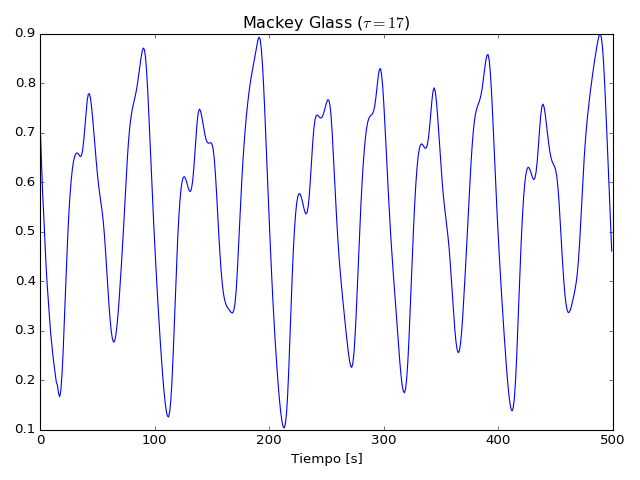

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

t = np.linspace(0, 499, 500)
plt.plot(t, X_train[0:500,0])
plt.title('Mackey Glass ($\\tau=17$)')
plt.xlabel('Tiempo [s]')
plt.tight_layout()

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../../'))

from deepensemble.utils.utils_functions import ActivationFunctions
from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.layers.recurrent import RecurrentLayer
from deepensemble.models.ensemblemodel import EnsembleModel
from deepensemble.combiner import *
from deepensemble.metrics import *
from deepensemble.utils import *

n_neurons = 12
n_models = 4
lr = 0.005
batch_size = 50
max_epoch = 300
fn_activation1 = ActivationFunctions.tanh
fn_activation2 = ActivationFunctions.sigmoid

In [4]:
# Create Ensemble
ensemble = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(n_models):
    net = Sequential("net%d_ens" % i)  # by default is a regressor
    net.add_layer(RecurrentLayer(n_input=X_train.shape[1], n_recurrent=n_neurons, activation=fn_activation1))
    net.add_layer(Dense(n_output=y_train.shape[1], activation=fn_activation1))
    net.append_cost(mse, name='MSE')
    net.set_update(sgd, name='SGD', learning_rate=lr)
    ensemble.append_model(net)

ensemble.set_combiner(AverageCombiner())
ensemble.compile(fast=True)

metrics_ensemble = FactoryMetrics.get_metric(ensemble)
                      
# training
metrics = ensemble.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False)
print("FINISHED!")

# Compute metricstrain
metrics_ensemble.append_metric(metrics)

Start Compile Ensemble  - elapsed: 21.60 [s]
Ensemble - fold: 1, epoch:[####################] 300/300 elapsed: 28.98[s] - left: 0.00[s] | error: -0.0019, score: 0.0080 / 0.0110
FINISHED!


In [5]:
# Create Ensemble NCL
ensembleNCL = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(n_models):
    net = Sequential("net%d_ens" % i)  # by default is a regressor
    net.add_layer(RecurrentLayer(n_input=X_train.shape[1], n_recurrent=n_neurons, activation=fn_activation1))
    net.add_layer(Dense(n_output=y_train.shape[1], activation=fn_activation1))
    net.append_cost(mse, name='MSE')
    net.set_update(sgd, name='SGD', learning_rate=lr)
    ensembleNCL.append_model(net)

ensembleNCL.add_cost_ensemble(fun_cost=neg_corr, name="NEG_CORR", lamb=0.2)
ensembleNCL.set_combiner(AverageCombiner())
ensembleNCL.compile(fast=True)

metrics_ensembleNCL = FactoryMetrics.get_metric(ensembleNCL)
                      
# training
metrics = ensembleNCL.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleNCL.append_metric(metrics)

Start Compile Ensemble  - elapsed: 18.27 [s]
Ensemble - fold: 2, epoch:[####################] 300/300 elapsed: 29.85[s] - left: 0.00[s] | error: -0.0025, score: 0.0090 / 0.0141
FINISHED!


In [6]:
# Create MLP

mlp = Sequential("MLP")  # by default is a regressor
mlp.add_layer(RecurrentLayer(n_input=X_train.shape[1], n_recurrent=n_neurons, activation=fn_activation1))
mlp.add_layer(Dense(n_output=y_train.shape[1], activation=fn_activation1))
mlp.append_cost(mse, name='MSE')
mlp.set_update(sgd, name='SGD', learning_rate=lr)

mlp.compile(fast=True)

metrics_mlp = FactoryMetrics.get_metric(mlp)
                      
# training
metrics = mlp.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False)
print("FINISHED!")

# Compute metricstrain
metrics_mlp.append_metric(metrics)

Start Compile MLP  - elapsed: 5.31 [s]
MLP - fold: 3, epoch:[####################] 300/300 elapsed: 10.64[s] - left: 0.00[s] | error: -0.0033, score: 0.0222 / 0.0255
FINISHED!


In [7]:
# Create Ensemble KLG
ensembleKLG = EnsembleModel(name="Ensemble")

# Create models for ensemble
for i in range(n_models):
    net = Sequential("net%d_ens" % i)  # by default is a regressor
    net.add_layer(RecurrentLayer(n_input=X_train.shape[1], n_recurrent=n_neurons, activation=fn_activation1))
    net.add_layer(Dense(n_output=y_train.shape[1], activation=fn_activation2))
    net.append_cost(kullback_leibler_generalized, name="KLG")
    net.set_update(sgd, name='SGD', learning_rate=lr)
    ensembleKLG.append_model(net)

ensembleKLG.add_cost_ensemble(fun_cost=neg_correntropy, name="NEG_CORRPY", lamb=0.8)
ensembleKLG.set_combiner(AverageCombiner())
ensembleKLG.compile(fast=True)

metrics_ensembleKLG = FactoryMetrics.get_metric(ensembleKLG)
                      
# training
metrics = ensembleKLG.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleKLG.append_metric(metrics)

Start Compile Ensemble  - elapsed: 37.73 [s]
Ensemble - fold: 4, epoch:[####################] 300/300 elapsed: 29.38[s] - left: 0.00[s] | error: 0.0275, score: 0.0051 / 0.0101
FINISHED!


<IPython.core.display.Javascript object>


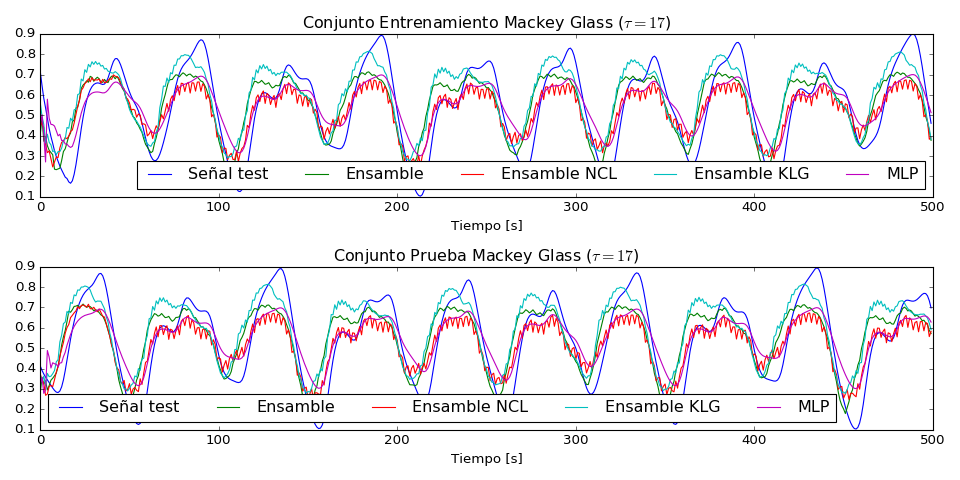

In [8]:
fig = plt.figure(figsize=(12, 6), dpi=80)

t = np.linspace(0, 499, 500)
plt.subplot(211)
plt.plot(t, X_train[0:500,0], label='Señal test')
plt.plot(t, ensemble.predict(X_train[0:500]), label='Ensamble')
plt.plot(t, ensembleNCL.predict(X_train[0:500]), label='Ensamble NCL')
plt.plot(t, ensembleKLG.predict(X_train[0:500]), label='Ensamble KLG')
plt.plot(t, mlp.predict(X_train[0:500]), label='MLP')
plt.title('Conjunto Entrenamiento Mackey Glass ($\\tau=17$)')
plt.xlabel('Tiempo [s]')
plt.legend(loc='best', ncol=5)

plt.subplot(212)
plt.plot(t, X_test[0:500,0], label='Señal test')
plt.plot(t, ensemble.predict(X_test[0:500]), label='Ensamble')
plt.plot(t, ensembleNCL.predict(X_test[0:500]), label='Ensamble NCL')
plt.plot(t, ensembleKLG.predict(X_test[0:500]), label='Ensamble KLG')
plt.plot(t, mlp.predict(X_test[0:500]), label='MLP')
plt.title('Conjunto Prueba Mackey Glass ($\\tau=17$)')
plt.xlabel('Tiempo [s]')
plt.legend(loc='best', ncol=5)

plt.tight_layout()

<IPython.core.display.Javascript object>


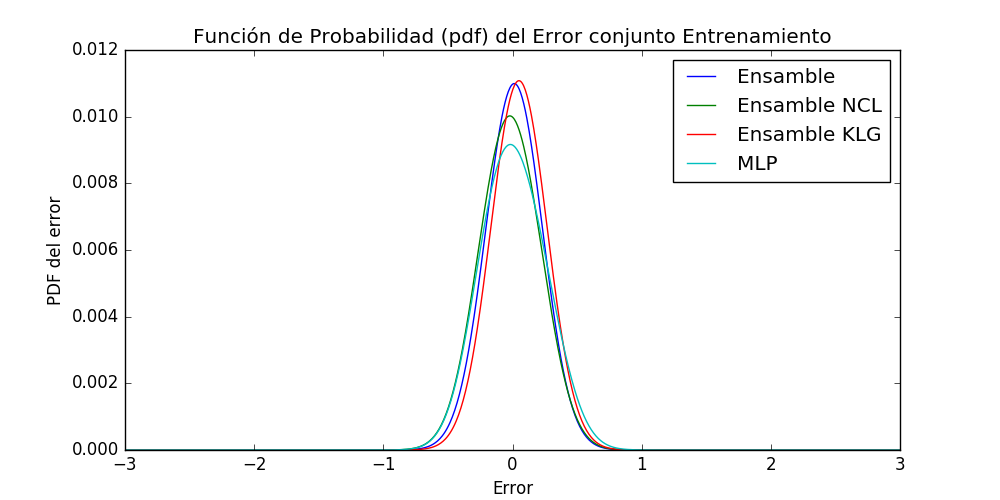

In [9]:
from sklearn.neighbors.kde import KernelDensity

def plot_pdf_error(pred, target, label_plot, ax, fig, n_points=1000, xmin=-3, xmax=3):
    error = pred - target
    N = len(error)
    s = 1.06 * np.std(error) / np.power(N, 0.2)  # Silverman
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
    kde.fit(error)
    x_plot = np.linspace(xmin, xmax, n_points)[:, np.newaxis]
    y_plot = np.exp(kde.score_samples(x_plot))
    ax.plot(x_plot, y_plot / np.sum(y_plot), label=label_plot)
    
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(ensemble.predict(X_train), y_train, 'Ensamble', ax, fig)
plot_pdf_error(ensembleNCL.predict(X_train), y_train, 'Ensamble NCL', ax, fig)
plot_pdf_error(ensembleKLG.predict(X_train), y_train, 'Ensamble KLG', ax, fig)
plot_pdf_error(mlp.predict(X_train), y_train, 'MLP', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error conjunto Entrenamiento")
plt.legend()

<IPython.core.display.Javascript object>


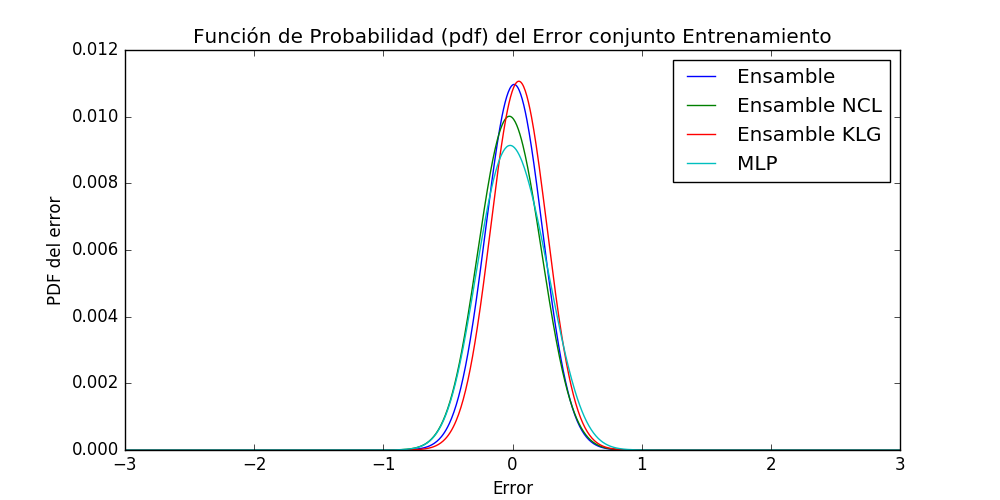

In [10]:
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(ensemble.predict(X_test), y_test, 'Ensamble', ax, fig)
plot_pdf_error(ensembleNCL.predict(X_test), y_test, 'Ensamble NCL', ax, fig)
plot_pdf_error(ensembleKLG.predict(X_test), y_test, 'Ensamble KLG', ax, fig)
plot_pdf_error(mlp.predict(X_test), y_test, 'MLP', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error conjunto Entrenamiento")
plt.legend()

In [11]:
score_test_ensemble = ensemble.score(X_test, y_test)
score_train_ensemble = ensemble.score(X_train, y_train)

score_test_ensembleNCL = ensembleNCL.score(X_test, y_test)
score_train_ensembleNCL = ensembleNCL.score(X_train, y_train)

score_test_ensembleKLG = ensembleKLG.score(X_test, y_test)
score_train_ensembleKLG = ensembleKLG.score(X_train, y_train)

score_test_mlp = mlp.score(X_test, y_test)
score_train_mlp = mlp.score(X_train, y_train)

print('Score RMS')
print('Ensamble: %f / %f' % (score_train_ensemble, score_test_ensemble))
print('Ensamble NCL: %f / %f' % (score_train_ensembleNCL, score_test_ensembleNCL))
print('Ensamble KLG: %f / %f' % (score_train_ensembleKLG, score_test_ensembleKLG))
print('MLP: %f / %f' % (score_train_mlp, score_test_mlp))

Score RMS
Ensamble: 0.007403 / 0.007579
Ensamble NCL: 0.015637 / 0.015809
Ensamble KLG: 0.009007 / 0.009044
MLP: 0.024330 / 0.024605
